In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import numpy as np

import pandas as pd

from scipy import linalg
from scipy.spatial import Voronoi, voronoi_plot_2d

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [4]:
flags = pd.read_feather('../data/all_flags.feather')
tf_idf = pd.read_feather('../data/flag_description_tf_idf.feather')

In [5]:
flags

,Flag(s),State,Aspect ratio,Date of latest adoption,Designer(s),Description,path
0,Afghanistan (Islamic Emirate),Afghanistan,0.500000,2021-08-15,None,White with a black Shahada in Thuluth scrip...,..\data\flags\0-220px-Flag_of_the_Taliban.svg.png
1,Afghanistan (Islamic Republic),Afghanistan,0.666667,2013-08-19,None,Three equal vertical bands of black ( hoist s...,..\data\flags\1-220px-Flag_of_Afghanistan_%282...
2,Albania,Albania,0.714286,1992-04-07,None,Red with a black double-headed eagle in the ...,..\data\flags\2-220px-Flag_of_Albania.svg.png
3,Algeria,Algeria,0.666667,1962-07-03,Disputed,Two equal vertical bands of green (hoist side)...,..\data\flags\3-250px-Flag_of_Algeria.svg.png
4,Andorra,Andorra,0.700000,1993-05-05,None,"Three vertical bands of blue (hoist side), yel...",..\data\flags\4-220px-Flag_of_Andorra.svg.png
...,...,...,...,...,...,...,...
208,Somaliland,Somaliland,NaN,1996-10-14,None,"Three equal horizontal bands of green (top), w...",..\data\flags\208-220px-Flag_of_Andorra.svg.png
209,South Ossetia,South Ossetia,NaN,NaT,None,"Three equal horizontal bands of white (top), r...",..\data\flags\209-220px-Flag_of_Angola.svg.png
210,Taiwan,Taiwan,0.666667,1928-10-28,Lu Haodong (canton) Sun Yat-sen (red field),Red field with a dark blue rectangle in the up...,..\data\flags\210-220px-Flag_of_Antigua_and_Ba...
211,Transnistria,Transnistria,0.500000,2000-07-03,None,"Three horizontal bands of red (top), green (ha...",..\data\flags\211-220px-Flag_of_Argentina.svg.png


In [6]:
data = pd.DataFrame({'flag-country': flags.apply(lambda r: f'{r['Flag(s)']}-{r['State']}', axis=1)}).join(tf_idf)
data

,flag-country,white,with,a,black,,shahada,in,thuluth,script,...,tiara,base,zimbabwe,dexter,hand,appaumé,kosovo,arrayed,slight,outline
0,Afghanistan (Islamic Emirate)-Afghanistan,0.020678,0.026676,0.022755,0.088128,0.0,0.266417,0.079238,0.291759,0.248437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,Afghanistan (Islamic Republic)-Afghanistan,0.008070,0.010410,0.000000,0.034391,0.0,0.000000,0.015461,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,Albania-Albania,0.000000,0.032832,0.028006,0.108465,0.0,0.000000,0.048762,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,Algeria-Algeria,0.010339,0.000000,0.022755,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,Andorra-Andorra,0.000000,0.008369,0.000000,0.000000,0.0,0.000000,0.012429,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Somaliland-Somaliland,0.026120,0.000000,0.019162,0.037107,0.0,0.112176,0.033363,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
209,South Ossetia-South Ossetia,0.022057,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
210,Taiwan-Taiwan,0.015039,0.038802,0.033098,0.000000,0.0,0.000000,0.028814,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
211,Transnistria-Transnistria,0.000000,0.009485,0.024272,0.000000,0.0,0.000000,0.014087,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11914


In [7]:
X = tf_idf
Y = data['flag-country']

In [8]:

pca = PCA().fit(X)

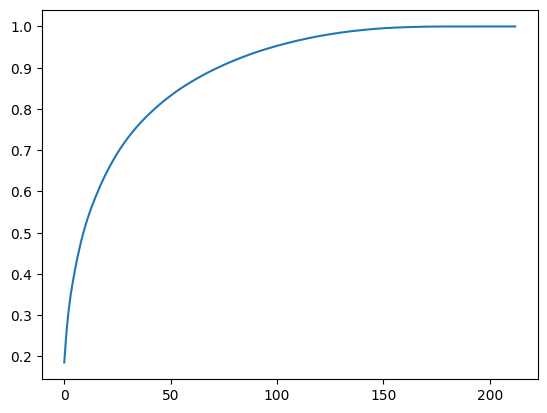

In [9]:
fig, ax = plt.subplots()

cum_var = np.sqrt(np.cumsum(pca.singular_values_**2) / np.sum(pca.singular_values_**2))
ax.plot(cum_var)

plt.show()

In [10]:
all_var = np.searchsorted(cum_var, 0.99)
all_var

np.int64(138)

In [11]:
pca.n_components_

213

In [12]:
all_var = 100

In [13]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from tempfile import mkdtemp

cachedir = mkdtemp()
categorizers = list()

for pca_modes in [2, 3, 5, 10, 20, 50, 100, all_var]:
    for k in range(3, 31):
        pipe = make_pipeline(
            PCA(n_components=pca_modes, random_state=932),
            KMeans(n_clusters=k, random_state=42),
            memory=cachedir
        )
        
        categorizers.append(pipe)

model_metrics = dict()
for cat in categorizers:
    cat.fit(X, Y)
    labels = cat.predict(X)
    categories = {label: Y[labels == label].values for label in np.unique(labels)}
    avg = np.average(list(map(len, categories.values())))
    # var = np.average((np.fromiter(map(len, categories.values()), dtype=int) - avg)**2)
    silhouette_score = metrics.silhouette_score(X, cat.get_params()['kmeans'].labels_, metric='euclidean')
    model_metrics[cat] = silhouette_score

best = pipe = max(categorizers, key=model_metrics.get)
print(best.get_params()['pca__n_components'], best.get_params()['kmeans__n_clusters'], model_metrics[best])

categories = {label: Y[labels == label].values for label in np.unique(labels)}

5 3 0.23254838843783782


In [14]:
# for model, metric in model_metrics.items():
#     print(f'k={model.get_params()['kmeans__n_clusters']}\t: {metric}')

In [15]:
# Handpicked model

best = pipe = make_pipeline(
    PCA(n_components=2),
    KMeans(n_clusters=10)
)

best.fit(X)

Pipeline(steps=[('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=10))])

In [16]:
centers_2d = pipe.named_steps['kmeans'].cluster_centers_[:, :2]

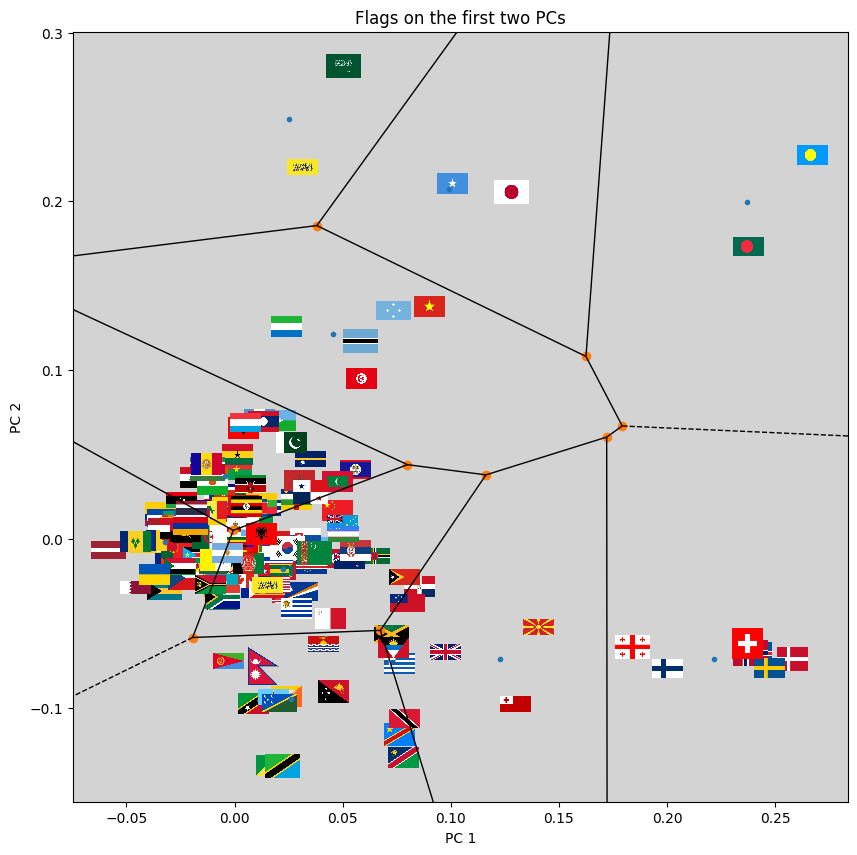

In [17]:

fig, ax = plt.subplots(figsize=(10,10))

pts = (X @ pca.components_[:2].T).T.values
# plt.scatter(*pts)

for i, (x, y) in enumerate(pts.T):
    image = plt.imread(flags['path'][i])
    offset_img = OffsetImage(image, zoom=0.1)
    abb = AnnotationBbox(offset_img, (x, y), xycoords='data', frameon=False, zorder=0)
    ax.add_artist(abb)

ax.update_datalim(pts.T)
ax.autoscale()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# plt.scatter(*centers_2d.T, zorder=20, color='r', alpha=0.5)
voronoi_plot_2d(Voronoi(centers_2d), ax=ax)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Flags on the first two PCs')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_facecolor('lightgray')
fig.savefig('../writeup/res/flag-pca.pdf')

plt.show()

In [18]:
# want to analyze the principal components for patterns

components = pca.inverse_transform(pca.components_[:3] @ X.T)
components.columns = tf_idf.columns

for idx, component in components.iterrows():
    sorted_words = sorted(components.columns, key=lambda c: component[c])
    
    print(f'{idx}: {sorted_words[:3]} vs {sorted_words[-3:]}')


0: ['yellow', 'crown', 'bright'] vs ['band', 'elliptical', 'a']
1: ['vermilion', 'austria', 'nine'] vs ['shahada', 'flag', 'five']
2: ['closed', 'national', '2'] vs ['stripe', 'extending', 'radiant']


"elliptical" only shows up in the description for Costa Rica, and two of these words are conjunctions, this may not actually be that useful.

In [19]:
# Let's try to see what the "average" flag per category is described as
# I'm not sure how to 'undo' tf-idf, but luckily sklearn has a TfidfVectorizer, which I will hopefully implement soon...

avg_flags = pd.DataFrame(pipe.named_steps['pca'].inverse_transform(pipe.named_steps['kmeans'].cluster_centers_), columns=pipe.feature_names_in_)
avg_flags

,white,with,a,black,,shahada,in,thuluth,script,the,...,tiara,base,zimbabwe,dexter,hand,appaumé,kosovo,arrayed,slight,outline
0,0.011376,0.007563,0.010273,0.014843,-2.331132e-19,0.002264,0.010702,0.001758,0.002703,0.009761,...,0.000638,0.000500,0.000500,0.000583,0.000583,0.000583,0.000991,0.000991,0.000991,0.000663
1,0.008437,0.015104,0.020097,0.005250,-8.085233e-19,-0.010928,0.012155,-0.011357,-0.010475,0.023131,...,0.000180,0.000194,0.000194,0.000951,0.000951,0.000951,0.000917,0.000917,0.000917,0.000300
2,0.014888,0.019395,0.015330,0.010844,2.898308e-18,0.031396,0.025786,0.033045,0.029693,0.012897,...,0.000129,0.000250,0.000250,-0.000081,-0.000081,-0.000081,0.000210,0.000210,0.000210,0.000211
3,0.008171,0.007001,0.013907,0.010900,-1.890524e-18,-0.017755,0.005197,-0.019124,-0.016404,0.016284,...,0.000584,0.000426,0.000426,0.001079,0.001079,0.001079,0.001277,0.001277,0.001277,0.000640
4,0.007962,0.022164,0.026394,-0.000636,-2.169280e-19,-0.009319,0.017103,-0.009106,-0.009458,0.030650,...,-0.000190,-0.000028,-0.000028,0.000947,0.000947,0.000947,0.000662,0.000662,0.000662,-0.000007
5,0.010604,0.010634,0.013733,0.011514,-2.566018e-19,-0.000504,0.011963,-0.000872,-0.000172,0.014273,...,0.000462,0.000388,0.000388,0.000668,0.000668,0.000668,0.000926,0.000926,0.000926,0.000521
6,0.017338,0.027587,0.018809,0.008098,5.074868e-18,0.051671,0.036256,0.054816,0.048481,0.015030,...,-0.000223,0.000078,0.000078,-0.000544,-0.000544,-0.000544,-0.000331,-0.000331,-0.000331,-0.000102
7,0.012476,0.011540,0.012075,0.013390,7.796781e-19,0.011565,0.015646,0.011763,0.011305,0.010991,...,0.000465,0.000414,0.000414,0.000372,0.000372,0.000372,0.000735,0.000735,0.000735,0.000510
8,0.016421,0.037036,0.027593,-0.000160,5.727280e-18,0.052105,0.042436,0.056039,0.048195,0.025709,...,-0.000725,-0.000227,-0.000227,-0.000506,-0.000506,-0.000506,-0.000650,-0.000650,-0.000650,-0.000516
9,0.019011,0.024439,0.014139,0.012711,5.536662e-18,0.059916,0.036353,0.063140,0.056600,0.008468,...,-0.000020,0.000219,0.000219,-0.000766,-0.000766,-0.000766,-0.000337,-0.000337,-0.000337,0.000056


In [20]:
# This runs really slow for some reason

fig, ax = plt.subplots()

for label, group in categories.items():
    for i, flag in enumerate(group):
        image = plt.imread(flags[data['flag-country'] == flag]['path'].values[0])
        offset_img = OffsetImage(image, zoom=0.1)
        abb = AnnotationBbox(offset_img, (label, i))
        ax.add_artist(abb)

ax.autoscale()

plt.show()

MemoryError: bad allocation

<Figure size 640x480 with 1 Axes>

# GMMs

In [21]:

gmm_models = list()
gmm_metrics = dict()

gmm_cache = mkdtemp()

for pc_modes in [2, 3, 5, 10, 20, 50, 100, all_var]:
    for components in range(2, 30):
        gmm = make_pipeline(
            PCA(n_components=pc_modes),
            GaussianMixture(n_components=5),
            memory=gmm_cache
        )
        gmm_models.append(gmm)

        gmm.fit(X)
        gmm_metrics[gmm] = metrics.silhouette_score(X, gmm.predict(X), metric='euclidean')

best_gmm = max(gmm_models, key=gmm_metrics.get)
print(f'Best GMM: {best_gmm.get_params()['pca__n_components']}, {best_gmm.get_params()['gaussianmixture__n_components']}: {gmm_metrics[best_gmm]}')

Best GMM: 50, 5: 0.2527551100604252


In [22]:
best_gmm = make_pipeline(
    PCA(n_components=2),
    GaussianMixture(n_components=5),
    memory=gmm_cache
)

best_gmm.fit(X)

metrics.silhouette_score(X, best_gmm.predict(X), metric='euclidean')

np.float64(0.025011106578057874)

In [ ]:
import pickle

with open('./best_gmm.pkl', mode='wb') as f:
    pickle.dump(best_gmm, f)

# with open('./best_gmm.pkl', mode='rb') as f:
#     best_gmm = pickle.load(f)

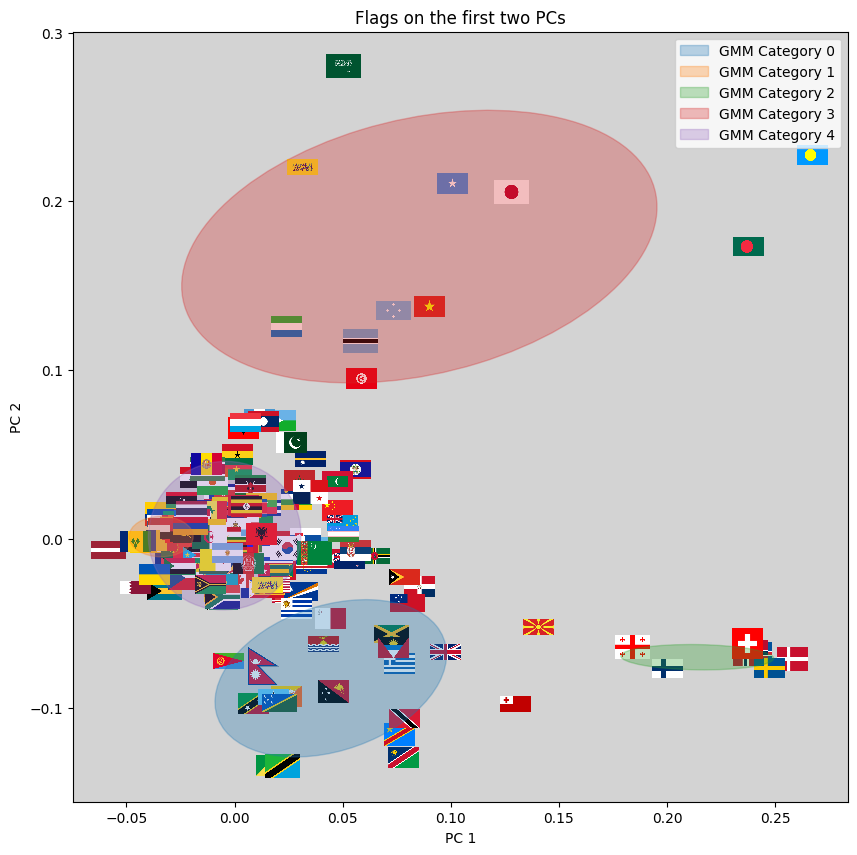

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

pcs = [0, 1]
pts = (X @ pca.components_[pcs].T).T.values
# plt.scatter(*pts)

for i, (x, y) in enumerate(pts.T):
    image = plt.imread(flags['path'][i])
    offset_img = OffsetImage(image, zoom=0.1)
    abb = AnnotationBbox(offset_img, (x, y), xycoords='data', frameon=False, zorder=0)
    ax.add_artist(abb)

ax.update_datalim(pts.T)
ax.autoscale()

means = best_gmm.get_params()['gaussianmixture'].means_
covariances = best_gmm.get_params()['gaussianmixture'].covariances_
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
for i, (mean, covar, color) in enumerate(zip(means, covariances, colors)):
    v, w = linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[pcs[0]] / linalg.norm(w[pcs[0]])

    # Plot an ellipse to show the Gaussian component
    angle = np.atan2(u[pcs[1]], u[pcs[0]])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[pcs[0]], v[pcs[1]], angle=180.0 + angle, color=color, label=f"GMM Category {i}")
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.3)
    ax.add_artist(ell)

ax.set_title('Flags on the first two PCs')
ax.set_xlabel(f'PC {pcs[0]+1}')
ax.set_ylabel(f'PC {pcs[1]+1}')
ax.set_facecolor('lightgray')
ax.legend()

fig.savefig('../writeup/res/flag-gmm.pdf')

plt.show()

In [25]:
gmm_categories = dict()

for flag, cat in zip(flags['Flag(s)'], best_gmm.predict(X)):
    l = gmm_categories.get(int(cat), list())
    l.append(flag)
    gmm_categories[int(cat)] = l

{cat: len(values) for cat, values in gmm_categories.items()}

{3: 11, 1: 94, 4: 80, 0: 21, 2: 7}

In [26]:
from tabulate import tabulate

print(tabulate(gmm_categories, headers=gmm_categories.keys()))

3                              1                                 4                         0                                 2
-----------------------------  --------------------------------  ------------------------  --------------------------------  -----------
Afghanistan (Islamic Emirate)  Afghanistan (Islamic Republic)    Albania                   Bhutan                            Denmark
Bangladesh                     Algeria                           Andorra                   Democratic Republic of the Congo  Finland
Botswana                       Angola                            Argentina                 Republic of the Congo             Georgia
Japan                          Antigua and Barbuda               Australia                 Dominican Republic                Iceland
Micronesia                     Armenia                           State flag of Austria     Greece                            Norway
Palau                          Civil flag of Austria             Bahamas

# Combined k-means GMM plot

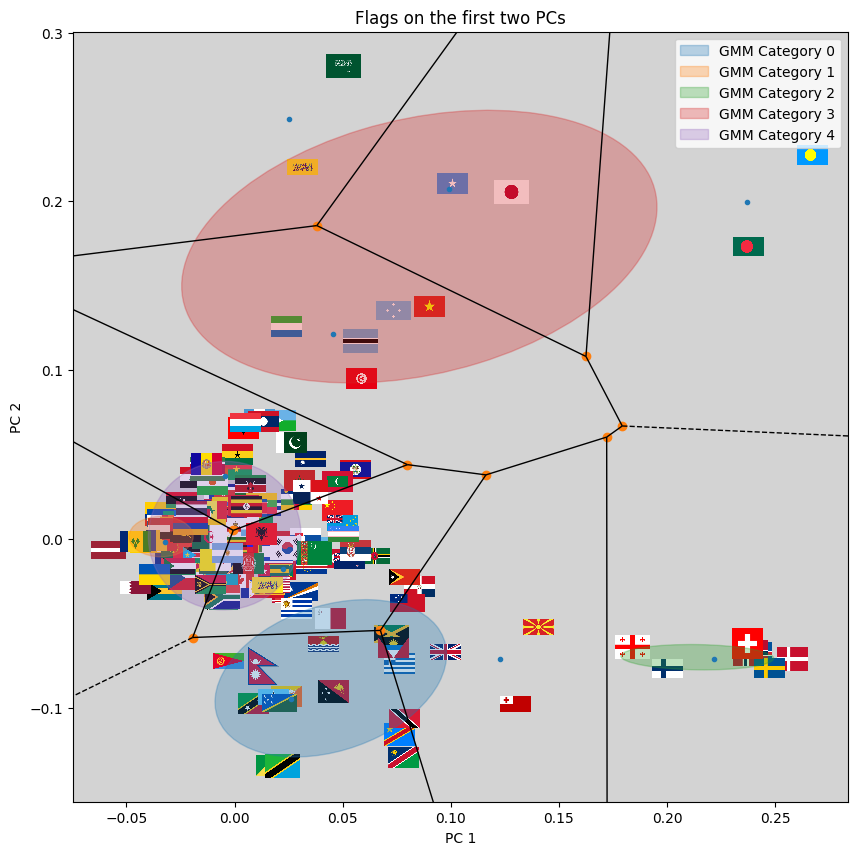

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

pcs = [0, 1]
pts = (X @ pca.components_[pcs].T).T.values
# plt.scatter(*pts)

# Plot the points
for i, (x, y) in enumerate(pts.T):
    image = plt.imread(flags['path'][i])
    offset_img = OffsetImage(image, zoom=0.1)
    abb = AnnotationBbox(offset_img, (x, y), xycoords='data', frameon=False, zorder=0)
    ax.add_artist(abb)

ax.update_datalim(pts.T)
ax.autoscale()

# Plot the GMM confidence intervals
means = best_gmm.get_params()['gaussianmixture'].means_
covariances = best_gmm.get_params()['gaussianmixture'].covariances_
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
for i, (mean, covar, color) in enumerate(zip(means, covariances, colors)):
    v, w = linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[pcs[0]] / linalg.norm(w[pcs[0]])

    # Plot an ellipse to show the Gaussian component
    angle = np.atan2(u[pcs[1]], u[pcs[0]])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[pcs[0]], v[pcs[1]], angle=180.0 + angle, color=color, label=f"GMM Category {i}")
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.3)
    ax.add_artist(ell)

# Plot the k-means clusters as a Voronoi diagram
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# plt.scatter(*centers_2d.T, zorder=20, color='r', alpha=0.5)
voronoi_plot_2d(Voronoi(centers_2d), ax=ax)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Titles etc
ax.set_title('Flags on the first two PCs')
ax.set_xlabel(f'PC {pcs[0]+1}')
ax.set_ylabel(f'PC {pcs[1]+1}')
ax.set_facecolor('lightgray')
ax.legend()

fig.savefig('../writeup/res/flags-kmeans-gmm.pdf')

plt.show()

# Unique Flags

In [28]:
from  scipy.spatial.distance import cdist

pca138 = PCA(138).fit(X)
reduced = pca138.transform(X)

distances = cdist(reduced, reduced, metric='euclidean')

no_self_dist = distances.copy()
no_self_dist[np.diag_indices(distances.shape[0])] = np.inf

dist_table = pd.DataFrame(data={'flag-country': Y,
                                'avg_dist': np.mean(distances, axis=1),
                                'min_dist': np.min(no_self_dist, axis=1)},)
dist_table.sort_values(by='min_dist', inplace=True, ascending=False)
dist_table

,flag-country,avg_dist,min_dist
48,Cyprus-Cyprus,0.664156,0.588161
24,Wiphala-Bolivia,0.642605,0.577945
152,Saint Lucia-Saint Lucia,0.657575,0.565402
175,Switzerland-Switzerland,0.636224,0.556669
205,Kosovo-Kosovo,0.622584,0.543162
...,...,...,...
141,Paraguay (reverse)-Paraguay,0.388648,0.000000
103,Lithuania-Lithuania,0.303980,0.000000
87,Ivory Coast-Ivory Coast,0.363996,0.000000
109,Mali-Mali,0.312469,0.000000


In [29]:
dist_table[dist_table['flag-country'] == 'Canada-Canada']

,flag-country,avg_dist,min_dist
34,Canada-Canada,0.490687,0.392147
